# **Transformers for Sentiment Classification:**

Welcome folks!, in the current project I will show you in detail how to implement four types of well-known transformer models making use of the transformers HuggingFace library and Keras API.

The main task corresponds to a multi-class text classification on Movie Reviews Competition and the dataset contains 156.060 instances for training, whereas the testing set contains 66.292 from which we have to classify among 5 classes. The sentiment labels are:

0 → Negative
1 → Somewhat negative
2 → Neutral
3 → Somewhat positive
4 → Positive
At the end of the project we will summarize and compare their performance according to our requirements and metrics.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-food-reviews-100k-datasets/amazon Food Reviews 100k Dataset.csv


In [2]:
import os 
!pip install -U -q segmentation-models --user
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
!pip install Keras

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

In [5]:

#df=pd.read_csv("../input/amazon-reviews-on-sentiment-analysis/Amazon Reviews on Sentiment Analysis/train.csv")
#encoding='latin1', lineterminator='\n'
dframe = pd.read_csv("../input/amazon-food-reviews-100k-datasets/amazon Food Reviews 100k Dataset.csv")
#df, validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

Just to confirm the number of instances and features in each file:

In [6]:
df = dframe.sample(frac=0.8, random_state=25)
df_test = dframe.drop(df.index)

print(f"No. of training examples: {df.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")

No. of training examples: 80000
No. of testing examples: 20000


In [7]:
#df_test=pd.read_csv("../input/amazon-reviews-on-sentiment-analysis/Amazon Reviews on Sentiment Analysis/test.csv")
#encoding='latin1', lineterminator='\n'

In [8]:
df.shape, df_test.shape

((80000, 3), (20000, 3))

In [9]:
df

,Id,Rating,Review
43469,43470,5,Love these almonds! Great flavor -- really hi...
20973,20974,5,"I really enjoy this green tea, this is my favo..."
42833,42834,5,I received a sample of one Newman's dark-choco...
1568,1569,5,"Love it, love it, love it! Both me and my 10 ..."
83899,83900,5,"If you like Huckleberries, this one is for you..."
...,...,...,...
82676,82677,5,I ordered these direct from the manufacturer i...
59663,59664,5,Many dry grain free foods are good but few giv...
44745,44746,1,My coworker brought these into the office toda...
23420,23421,4,"I like a nice pork chop from time to time, and..."


Above we can see that Review and Rating columns are all we need from the file in order to train the models later, therefore we will use these as feature (X) and label (Y) when fitting the transformer.

In [10]:
df_test

,Id,Rating,Review
20,21,5,My husband is a Twizzlers addict. We've bough...
22,23,5,I can remember buying this candy as a kid and ...
29,30,5,I don't know if it's the cactus or the tequila...
49,50,3,This is the same stuff you can buy at the big ...
50,51,1,"This oatmeal is not good. Its mushy, soft, I d..."
...,...,...,...
99967,99968,5,"The spice and flavor go hand-in-hand, so I usu..."
99980,99981,5,I bought this product strictly on the review o...
99985,99986,5,Just about any nong shim soup is good. Most of...
99989,99990,5,"I been to several places around the world, inc..."


In case there is a null or empty value in any column we should have to get rid of it, in order to find it out we will use info() as follows:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 43469 to 47227
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      80000 non-null  int64 
 1   Rating  80000 non-null  int64 
 2   Review  80000 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.4+ MB


In [12]:
df.isnull().sum()

Id        0
Rating    0
Review    0
dtype: int64

The dataset looks good and we need to know how are distributed the 5 classes in the label so as to know it's balanced or not.

In [13]:
df.Rating.value_counts()

5    49945
4    11712
1     7452
3     6424
2     4467
Name: Rating, dtype: int64

<AxesSubplot:title={'center':'Pie chart of Rating Class'}, ylabel='Rating'>

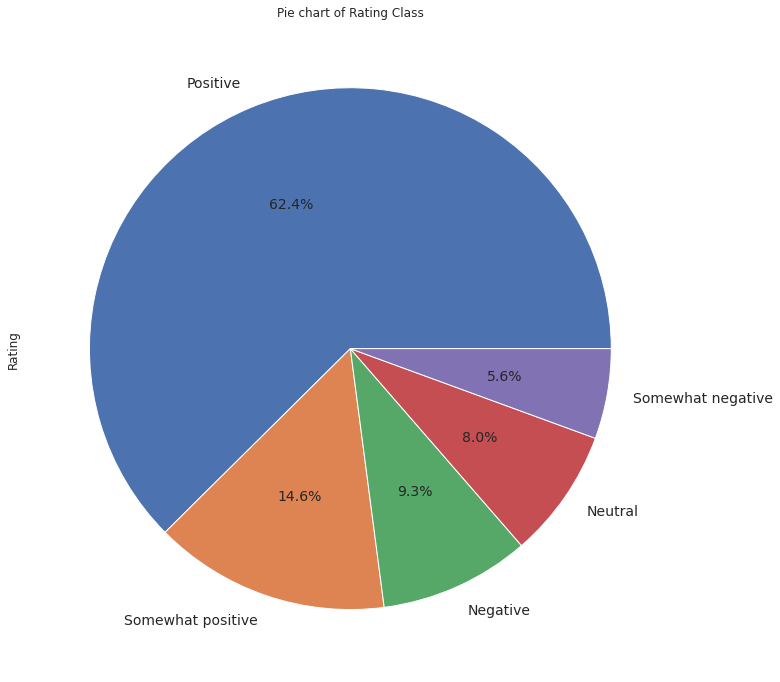

In [14]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['Rating'].replace(1,'Negative').replace(2,'Somewhat negative').replace(3,'Neutral').replace(4,'Somewhat positive').replace(5,'Positive').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Rating Class',y = 'Rating', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class

Text(0.5, 0.98, 'Histogram number of words in reviews')

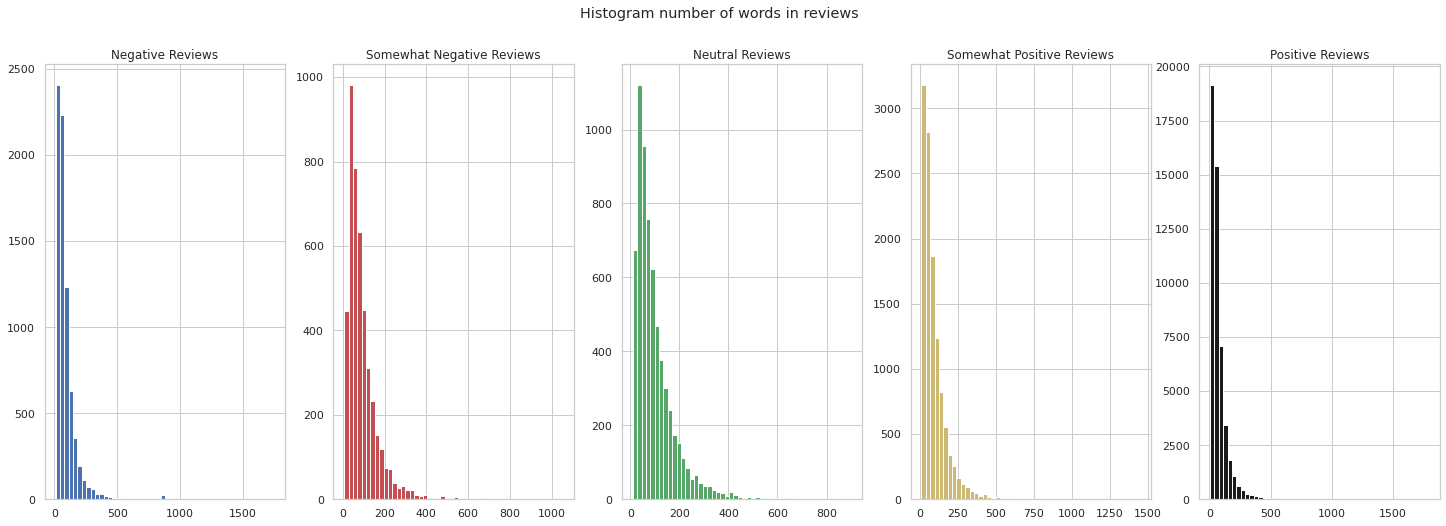

In [15]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df[df['Rating'] == 1]['Review'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(df[df['Rating'] == 2]['Review'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(df[df['Rating'] == 3]['Review'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(df[df['Rating'] == 4]['Review'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(df[df['Rating'] == 5]['Review'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In the 5 histograms we can see the distribution behaves like a negative exponential function decreasing significatively as the x-axis increases. It seems like the longest sentence in Review column corresponds to a class 'Negative Reviews' and is around 52 words, now let's obtain the longest one by using the max() function:

In [16]:
df['Review'].str.split().map(lambda x: len(x)).max()

1791

In [17]:
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')

Number of sentences which contain more than 20 words:  77709
 
Number of sentences which contain more than 30 words:  64930
 
Number of sentences which contain more than 40 words:  54513
 
Number of sentences which contain more than 50 words:  45878
 
Number of sentences which contain 52 words:  800
 


Modeling
In this step we will build, train and compare the following algorithms:

BERT (Bidirectional Encoder Representation from Transformers)

XLNet (Generalized Auto-Regressive model)

RoBERTa (Robustly Optimized BERT Pre-training Approach)

DistilBERT (Distilled BERT)

Each one of the mentioned have its pros and cons, the most preferred and widely used model is the BERT for being the middle term in performance, whereas RoBERTa and .. are known for their better error metrics and DistilBERT for its faster training. We will consider all of these chracteristics and choose the best one for our dataset.

Firstly, we have to install the transformers library offered by HuggingFace so as enable all useful functions when building the four models.

In [18]:
!pip install transformers

Then what we need from tensorflow.keras:

In [19]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

Now we have to gather from the dataset only the two columns useful for training (Review and Rating):

In [20]:
data = df[['Review', 'Rating']]

# Set your model output as categorical and save in new label col
data['Rating_label'] = pd.Categorical(data['Rating'])

# Transform your output to numeric
data['Rating'] = data['Rating_label'].cat.codes

In [21]:
data_train, data_val = train_test_split(data, test_size = 0.1)

# **BERT:**



As first step we have to import the Model, Config and Tokenizer corresponding to Bert in order to build properly the model.

In [22]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

2022-09-15 16:16:24.717301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 16:16:24.718461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 16:16:24.719151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 16:16:24.721482: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Now that our model has been loaded we can start the processes of building and tuning according to our dataset and task using the functional API of keras.

In [24]:
### ------- Build the model ------- ###

# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


The next cell considers the tokenization of training and testing sentences, setting of label as categorical and finally model training.

In [25]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)
# Fit the model
history = model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
    
    batch_size=64,
    epochs=10,
    verbose=1)

2022-09-15 16:17:27.430896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1125/1125 [==============================] - 413s 356ms/step - loss: 0.8147 - accuracy: 0.6977
Epoch 2/10
1125/1125 [==============================] - 400s 356ms/step - loss: 0.7063 - accuracy: 0.7336
Epoch 3/10
1125/1125 [==============================] - 401s 356ms/step - loss: 0.6741 - accuracy: 0.7460
Epoch 4/10
1125/1125 [==============================] - 401s 356ms/step - loss: 0.6550 - accuracy: 0.7514
Epoch 5/10
1125/1125 [==============================] - 400s 356ms/step - loss: 0.6421 - accuracy: 0.7569
Epoch 6/10
1125/1125 [==============================] - 400s 356ms/step - loss: 0.6322 - accuracy: 0.7613
Epoch 7/10
1125/1125 [==============================] - 400s 356ms/step - loss: 0.6236 - accuracy: 0.7642
Epoch 8/10
1125/1125 [==============================] - 400s 356ms/step - loss: 0.6154 - accuracy: 0.7666
Epoch 9/10
1125/1125 [==============================] - 401s 356ms/step - loss: 0.6100 - accuracy: 0.7699
Epoch 10/10
1125/1125 [=======================

The model took 31 minutes and 16 seconds to train for 2 epochs.

# **Evaluate on Train+Test set(BERT):**

We will compute the error metrics on the validation set in order to have an idea of the model performance.

In [26]:
model_eval = model.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

2250/2250 [==============================] - 139s 61ms/step - loss: 0.5538 - accuracy: 0.7928


In [27]:
y_train_predicted = model.predict(
    x={'input_ids': x_train['input_ids']},
)

y_train_predicted corresponds to a numpy array representing the instances and the prediction as one-hot encoded, the actual label is formatted in the same manner, let's them see in detail:

In [28]:
y_train_predicted['Rating']

array([[-3.0887911 , -2.2344284 , -0.6008718 ,  2.654005  ,  3.6700273 ],
       [-2.739097  , -2.3630943 , -0.9470707 ,  1.8971869 ,  4.9117274 ],
       [-1.2466748 ,  0.09753612,  1.2070271 ,  0.4299408 , -1.0246402 ],
       ...,
       [-1.1762578 , -1.7726288 , -0.78291965,  1.063292  ,  3.5703707 ],
       [-2.9368355 , -2.1833668 , -0.4277881 ,  2.3133457 ,  3.9388754 ],
       [ 0.6916318 ,  1.8856144 ,  1.4496323 , -1.4086913 , -3.7088795 ]],
      dtype=float32)

In [29]:
y_train_predicted['Rating']

array([[-3.0887911 , -2.2344284 , -0.6008718 ,  2.654005  ,  3.6700273 ],
       [-2.739097  , -2.3630943 , -0.9470707 ,  1.8971869 ,  4.9117274 ],
       [-1.2466748 ,  0.09753612,  1.2070271 ,  0.4299408 , -1.0246402 ],
       ...,
       [-1.1762578 , -1.7726288 , -0.78291965,  1.063292  ,  3.5703707 ],
       [-2.9368355 , -2.1833668 , -0.4277881 ,  2.3133457 ,  3.9388754 ],
       [ 0.6916318 ,  1.8856144 ,  1.4496323 , -1.4086913 , -3.7088795 ]],
      dtype=float32)

In order to compute the classification report and confusion matrix we will convert the matrices to one column representing the argmax for each row:

In [30]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [31]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [32]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      7749
           1       0.33      0.57      0.42      2331
           2       0.52      0.61      0.56      4964
           3       0.37      0.64      0.47      6078
           4       0.96      0.85      0.90     50878

    accuracy                           0.79     72000
   macro avg       0.60      0.68      0.62     72000
weighted avg       0.85      0.79      0.81     72000



The fact that our dataset is unbalanced in classes makes our prediction absolutely sidetracked towards the most frequent class, in this case (2: 'Neutral'), because of this the performance of the model is poor when predicting classes 0 or 4, making our model almost unuseful for this task. Below we can see for these 2 classes the number of misclassifications is huge.

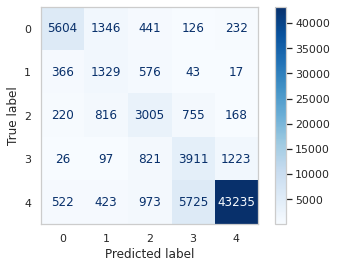

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(BERT):**

In this step we will predict the classes corresponding to the test set (out-of-bag) instances, because of the huge dataset we can expect to have almost same performance.

In [34]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [35]:
label_predicted = model.predict(
    x={'input_ids': x_test['input_ids']},
)

In [36]:
label_predicted['Rating']

array([[-1.554384  , -1.6787874 , -0.8391537 ,  1.1030827 ,  3.735324  ],
       [-2.8691418 , -2.4253855 , -0.903107  ,  2.4239686 ,  4.823783  ],
       [-2.906131  , -2.4126964 , -1.0280912 ,  2.203444  ,  4.9296927 ],
       ...,
       [-2.3757663 , -2.0126357 , -0.51723874,  1.8686974 ,  3.8955202 ],
       [-2.1121294 , -2.2412364 , -1.346896  ,  1.43084   ,  5.4834447 ],
       [-2.8060267 , -1.2373718 ,  1.1062068 ,  2.4402478 ,  0.39130306]],
      dtype=float32)

In [37]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [38]:
label_pred_max[:10]

[4, 4, 4, 0, 0, 4, 4, 0, 2, 4]

We will build the next 3 models the same way as the previous one, notice there are some lines which includes extra functions proper for the model:

In [39]:
#Cheers!!!

# **XLNet:**

The tokenizer corresponding to XLNet requires an extra library called sentencepiece which we have to install and import as follows:

In [40]:
!pip install sentencepiece 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
from transformers import XLNetTokenizer, TFXLNetModel, XLNetConfig
import sentencepiece

In [42]:
### --------- Setup XLNet ---------- ###

model_name = 'xlnet-base-cased'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = XLNetConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the XLNet model
transformer_xlnet_model = TFXLNetModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [43]:
from keras.layers import Input
import tensorflow as tf

In [44]:
### ------- Build the model ------- ###

# Load the MainLayer
xlnet = transformer_xlnet_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers XLNet model as a layer in a Keras model
xlnet_model = xlnet(inputs)[0]
xlnet_model = tf.squeeze(xlnet_model[:, -1:, :], axis=1)
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(xlnet_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model4 = Model(inputs=inputs, outputs=outputs, name='XLNet_MultiClass')

# Take a look at the model
model4.summary()

Model: "XLNet_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
transformer (TFXLNetMainLaye TFXLNetModelOutput(last_h 116718336 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1, 768)            0         
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 116,722,181
Trainable params: 116,722,181
Non-trainable params: 0
____________________________________

In [45]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model4.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
# Fit the model
history = model4.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
    
    batch_size=64,
    epochs=10,
    verbose=1)

Epoch 1/10
1125/1125 [==============================] - 494s 428ms/step - loss: 0.7931 - accuracy: 0.7044
Epoch 2/10
1125/1125 [==============================] - 482s 428ms/step - loss: 0.6932 - accuracy: 0.7375
Epoch 3/10
1125/1125 [==============================] - 482s 428ms/step - loss: 0.6690 - accuracy: 0.7441
Epoch 4/10
1125/1125 [==============================] - 481s 428ms/step - loss: 0.6528 - accuracy: 0.7504
Epoch 5/10
1125/1125 [==============================] - 481s 428ms/step - loss: 0.6389 - accuracy: 0.7577
Epoch 6/10
1125/1125 [==============================] - 481s 428ms/step - loss: 0.6296 - accuracy: 0.7594
Epoch 7/10
1125/1125 [==============================] - 481s 428ms/step - loss: 0.6230 - accuracy: 0.7624
Epoch 8/10
1125/1125 [==============================] - 481s 428ms/step - loss: 0.6163 - accuracy: 0.7645
Epoch 9/10
1125/1125 [==============================] - 481s 428ms/step - loss: 0.6116 - accuracy: 0.7653
Epoch 10/10
1125/1125 [=======================

The model took 31 minutes and 16 seconds to train for 2 epochs.

# **Evaluate on Train+Test set(XLNET):**

In [46]:
model_eval = model4.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

2250/2250 [==============================] - 164s 72ms/step - loss: 0.5507 - accuracy: 0.7895


In [47]:
y_train_predicted = model4.predict(
    x={'input_ids': x_train['input_ids']},
)

In [48]:
y_train_predicted['Rating']

array([[-4.0594974 , -3.1863575 , -1.0603781 ,  3.7093391 ,  6.0105276 ],
       [-1.2211388 , -1.4409119 ,  0.1769105 ,  1.1771266 ,  2.2890959 ],
       [-0.99449784,  0.597374  ,  1.9802884 ,  0.77319914, -1.5455021 ],
       ...,
       [-1.6181883 , -2.7315986 , -1.7240437 ,  1.6850588 ,  5.173804  ],
       [-3.6205997 , -3.3207574 ,  0.11187167,  2.8986206 ,  4.544386  ],
       [-0.16057968,  1.7409829 ,  1.8672512 , -0.27834573, -3.3948123 ]],
      dtype=float32)

In [49]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [50]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [51]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [52]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      7561
           1       0.33      0.58      0.42      2310
           2       0.51      0.58      0.54      5113
           3       0.35      0.62      0.45      5901
           4       0.97      0.85      0.90     51115

    accuracy                           0.79     72000
   macro avg       0.59      0.67      0.62     72000
weighted avg       0.85      0.79      0.81     72000



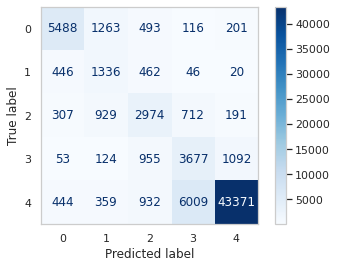

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(XLNET):**

In [54]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [55]:
label_predicted = model4.predict(
    x={'input_ids': x_test['input_ids']},
)

In [56]:
label_predicted['Rating']

array([[-2.122554  , -1.9381714 , -0.8360805 ,  0.9623415 ,  3.9152513 ],
       [-3.8694232 , -3.834713  , -0.78487504,  2.8822403 ,  5.8293557 ],
       [-2.6567378 , -2.3331065 , -0.664563  ,  1.5708618 ,  4.136845  ],
       ...,
       [-3.1627238 , -2.419576  , -0.9731422 ,  2.675517  ,  4.920042  ],
       [-0.6061825 , -1.0376428 , -1.1644613 ,  0.44241434,  3.447181  ],
       [-3.7125375 , -1.6743144 ,  2.0825925 ,  3.304546  ,  0.5749757 ]],
      dtype=float32)

In [57]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [58]:
label_pred_max[:10]

[4, 4, 4, 0, 0, 4, 4, 0, 0, 4]

We will build the next 2 models the same way as the previous one, notice there are some lines which includes extra functions proper for the model:

In [59]:
#Cheers!!!

# **RoBERTa:**

In [60]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

In [61]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [62]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model2 = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Take a look at the model
model2.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
roberta (TFRobertaMainLayer) TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 124,649,477
Trainable params: 124,649,477
Non-trainable params: 0
_________________________________________________________________


In [63]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model2.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)
# Fit the model
history = model2.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
  
    batch_size=64,
    epochs=10,
    verbose=1)

Epoch 1/10
1125/1125 [==============================] - 418s 360ms/step - loss: 0.7827 - accuracy: 0.7094
Epoch 2/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6851 - accuracy: 0.7393
Epoch 3/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6577 - accuracy: 0.7481
Epoch 4/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6442 - accuracy: 0.7535
Epoch 5/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6313 - accuracy: 0.7586
Epoch 6/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6247 - accuracy: 0.7616
Epoch 7/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6161 - accuracy: 0.7637
Epoch 8/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6099 - accuracy: 0.7673
Epoch 9/10
1125/1125 [==============================] - 405s 360ms/step - loss: 0.6054 - accuracy: 0.7682
Epoch 10/10
1125/1125 [=======================

The model took 26 minutes to train for 2 epochs.

# **Evaluate on validation set(RoBERTa):**

In [64]:
model_eval = model2.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

2250/2250 [==============================] - 139s 61ms/step - loss: 0.5555 - accuracy: 0.7877


In [65]:
y_train_predicted = model2.predict(
    x={'input_ids': x_train['input_ids']},
)

In [66]:
y_train_predicted['Rating']

array([[-2.8988376 , -2.7359693 , -0.8683769 ,  2.7985983 ,  4.15639   ],
       [-2.3691907 , -2.4260366 , -0.9290939 ,  1.7551353 ,  4.198169  ],
       [-0.83934176,  1.1897019 ,  1.8491069 ,  0.11886597, -2.1229198 ],
       ...,
       [-2.501429  , -2.4776938 , -1.2789053 ,  1.7695706 ,  4.366001  ],
       [-3.0210848 , -2.8533995 , -1.0990143 ,  2.5624468 ,  4.461936  ],
       [-0.47473034,  0.32499555,  1.0790261 ,  0.56358296, -1.1589831 ]],
      dtype=float32)

In [67]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [68]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [69]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [70]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      7534
           1       0.35      0.53      0.42      2639
           2       0.50      0.57      0.53      5132
           3       0.38      0.60      0.47      6719
           4       0.96      0.86      0.91     49976

    accuracy                           0.79     72000
   macro avg       0.60      0.65      0.62     72000
weighted avg       0.83      0.79      0.81     72000



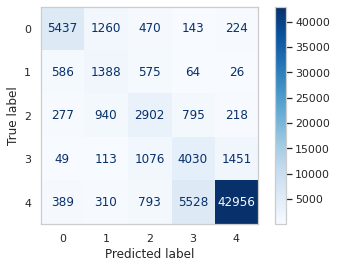

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(RoBERTa):**

In [72]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [73]:
label_predicted = model2.predict(
    x={'input_ids': x_test['input_ids']},
)

In [74]:
label_predicted['Rating']

array([[-1.0905075 , -1.2379562 , -0.89895356,  0.37323162,  2.8788774 ],
       [-2.4223976 , -2.7344236 , -1.5313286 ,  1.6401267 ,  5.2002234 ],
       [-2.496263  , -2.52402   , -1.2828547 ,  1.5204555 ,  4.707741  ],
       ...,
       [-2.831808  , -2.6778126 , -1.0499499 ,  2.3828254 ,  4.2486515 ],
       [-2.2107103 , -2.5851324 , -1.6354498 ,  1.1384045 ,  5.167436  ],
       [-2.365849  , -0.42274362,  2.1461635 ,  2.0822659 , -0.8541587 ]],
      dtype=float32)

In [75]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [76]:
label_pred_max[:10]

[4, 4, 4, 0, 0, 4, 4, 0, 0, 4]

In [77]:
#Cheers!!!

# **DistilBERT:**

In [78]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig 

In [79]:
### --------- Setup DistilBERT ---------- ###

model_name = 'distilbert-base-uncased'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Distilbert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Distilbert model
transformer_distilbert_model = TFDistilBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-09-15 20:15:57.344651: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

In [80]:
### ------- Build the model ------- ###

# Load the MainLayer
distilbert = transformer_distilbert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers DistilBERT model as a layer in a Keras model
distilbert_model = distilbert(inputs)[0][:,0,:]
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(distilbert_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model3 = Model(inputs=inputs, outputs=outputs, name='DistilBERT_MultiClass')

# Take a look at the model
model3.summary()

Model: "DistilBERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 66,366,725
Trainable params: 66,366,725
Non-trainable params: 0
_________________________________________________________________


In [81]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model3.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)
# Fit the model
history = model3.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
    
    batch_size=64,
    epochs=10,
    verbose=1)

Epoch 1/10
1125/1125 [==============================] - 211s 182ms/step - loss: 0.8364 - accuracy: 0.6900
Epoch 2/10
1125/1125 [==============================] - 205s 182ms/step - loss: 0.7403 - accuracy: 0.7209
Epoch 3/10
1125/1125 [==============================] - 205s 182ms/step - loss: 0.7152 - accuracy: 0.7318
Epoch 4/10
1125/1125 [==============================] - 205s 182ms/step - loss: 0.7001 - accuracy: 0.7362
Epoch 5/10
1125/1125 [==============================] - 204s 182ms/step - loss: 0.6902 - accuracy: 0.7404
Epoch 6/10
1125/1125 [==============================] - 204s 181ms/step - loss: 0.6817 - accuracy: 0.7431
Epoch 7/10
1125/1125 [==============================] - 204s 182ms/step - loss: 0.6746 - accuracy: 0.7459
Epoch 8/10
1125/1125 [==============================] - 205s 182ms/step - loss: 0.6697 - accuracy: 0.7474
Epoch 9/10
1125/1125 [==============================] - 205s 182ms/step - loss: 0.6647 - accuracy: 0.7505
Epoch 10/10
1125/1125 [=======================

The model took 14 minutes to train for 2 epochs.

# **Evaluate on Train+Test set(DistilBERT):**

In [82]:
model_eval = model3.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

2250/2250 [==============================] - 71s 31ms/step - loss: 0.6263 - accuracy: 0.7654


In [83]:
y_train_predicted = model3.predict(
    x={'input_ids': x_train['input_ids']},
)

In [84]:
y_train_predicted['Rating']

array([[-3.0929074 , -2.5546207 , -0.98670727,  2.6029522 ,  4.012602  ],
       [-2.3596725 , -2.7028239 , -1.3048707 ,  1.651142  ,  4.6218476 ],
       [-1.6698549 , -0.2514112 ,  0.79189175,  1.0653838 ,  0.01939713],
       ...,
       [-0.37110645, -1.1780595 , -0.42111433,  0.35784012,  2.1371493 ],
       [-2.677272  , -2.5968564 , -1.051451  ,  1.9096423 ,  4.231801  ],
       [ 0.5814584 ,  1.3031392 ,  1.3383704 , -0.4068093 , -1.822074  ]],
      dtype=float32)

In [85]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [86]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [87]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [88]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      7513
           1       0.28      0.50      0.36      2266
           2       0.42      0.55      0.48      4456
           3       0.32      0.58      0.41      5770
           4       0.96      0.83      0.89     51995

    accuracy                           0.77     72000
   macro avg       0.55      0.63      0.57     72000
weighted avg       0.83      0.77      0.79     72000



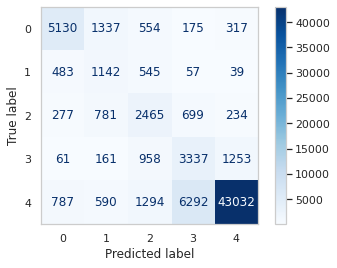

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(DistilBERT):**

In [90]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [91]:
label_predicted = model3.predict(
    x={'input_ids': x_test['input_ids']},
)

In [92]:
label_predicted['Rating']

array([[-1.4674356 , -2.0338812 , -1.0517372 ,  0.7704631 ,  3.6630292 ],
       [-2.910596  , -2.4511824 , -1.2718295 ,  2.38521   ,  4.435076  ],
       [-2.8463085 , -2.1331735 , -0.8777534 ,  1.9585103 ,  4.0832195 ],
       ...,
       [-2.9066572 , -2.1455736 , -0.24625131,  2.2018878 ,  3.2483993 ],
       [-1.6793844 , -2.0871096 , -1.6338614 ,  0.73980594,  4.553444  ],
       [-2.5575151 , -0.62184566,  2.1001656 ,  2.2890162 , -0.6006838 ]],
      dtype=float32)

In [93]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [94]:
label_pred_max[:10]

[4, 4, 4, 0, 0, 4, 4, 0, 0, 4]

In [95]:
#Cheers!!!

# **Discussion:**

In general the performance of the four models was similar, supporting the idea that BERT is the middle term of trade-off between accuracy and training time, whereas DistilBERT was the fastest by far, but having a lower accuracy than the previous as is explained by HuggingFace it achieves 95% accuracy of BERT, finally RoBERTa and XLNet were the models with highest accuracy and at the same time the slowest.

I have submitted the predition of the testing set for all models and the best one was RoBERTa reaching 68.62% of accuracy and the lowest was DistilBERT reaching 67.90%. We can say there is a slight difference but in terms of number of misclassifications the gap is huge, however the big challenge of the current task is how to deal with an unbalanced dataset, this is the main and perhaps the unique reason why we have such a poor performance even in the best one, despite the fact that increasing the max_length of sequences can increase a little bit the accuracy too, but not significatively. The method I would apply to solve this problem is undersampling in which we reduce the number of instances to the less frequent class which corresponds to 7.072 (Negative) as such number of instances is not too small and having 5 classes the dataset should finally have 35.360 sentences to compute, but obviously we are getting rid randomly of a big portion of the data.

Another possible solution could be to get rid of those reviews which are "vague" such as those with only one or two words classified as neutral, those really does not add too much to the training, but in contrast are others which have just a couple of words and are useful. This process would take a long time to do because it have to be done one by one, but it surely solves the problem.

Also I have to inform that I have trained for more than 2 epochs each model but the accuracy didn't increase or even decreased after the 3rd or 4th epoch, this is why in order to avoid more complex functions or early stopping I set to 2 epochs.

I would like to know any feedback in order to increase the performance of the models or tell me if you found a different one even better!

If you liked this notebook I would appreciate so much your upvote if you want to see more projects/tutorials like this one. I encourage you to see my projects portfolio, am sure you will love it.

Thank you!